In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
import anchors
from poola import core as pool

import core_functions as fns

gpp.set_aesthetics(palette='Set2')


## Functions 

In [3]:
#QC 

def add_guide_seq_col(df, guide_col = 'sgRNA'):
    df_match = df.copy()
    guide_seq_list = []

    for i, row in enumerate(df_match.loc[:,'sgRNA']):
        split_row = row.split('_')
        guide_seq =split_row[-1]
        guide_seq_list.append(guide_seq)
    
    df_match['match_guide'] = pd.Series(guide_seq_list)
    
    return df_match

def get_grouped_controls(df, control_name):
    '''
    Inputs:
    1. df: guide-gene annotation df 
    2. control_name: list of string identifiers for controls 
    Outputs:
    1. grouped_genes: controls grouped into pseudogenes with
    '''
    ungrouped_df = pd.DataFrame()
    for control in control_name:
        control_condition = (df['Gene Symbol'].str.contains(control, na=False))
        control_rows = df[control_condition]
        #if all controls have same Gene Symbol
        if len(set(control_rows['Gene Symbol'])) == 1:
            ungrouped_df = df.copy()
            # Give controls unique names before grouping 
            ungrouped_df.loc[control_condition, 'Gene Symbol'] = control + control_rows['Guide'] 
    
    ungrouped_genes = ungrouped_df.dropna()

    grouped_genes = pool.group_pseudogenes(ungrouped_genes[['Guide', 'Gene Symbol']], pseudogene_size=3, gene_col='Gene Symbol', control_regex = control_name)

    #grouped_controls = pd.concat([LibA_grouped_genes, LibB_grouped_genes])

    return grouped_genes

    
def match_pseudogenes(df, guide_mapping, control_name):
    '''
    Inputs: 
    1. df: data frame to which grouped pseudogene annotations will be merged 
    2. guide_mapping: guide-gene annotation data frame
    3. control_name: list containing substrings that identify controls 
    '''
    grouped_genes = get_grouped_controls(guide_mapping, control_name)
    grouped_df = pd.merge(grouped_genes, df, on = 'Guide', how = 'outer', suffixes = ['', '_old'])
    grouped_df.loc[:,'Gene Symbol'] = grouped_df.loc[:,'Gene Symbol'].fillna(grouped_df['Gene Symbol_old'])
    grouped_df = grouped_df.drop('Gene Symbol_old', axis = 1)

    return grouped_df

In [4]:
def run_guide_residuals(lfc_df, paired_lfc_cols):
    '''
    Calls get_guide_residuals function from anchors package to calculate guide-level residual z-scores
    Input:
    1. lfc_df: data frame with log-fold changes (relative to pDNA)
    
    '''
#     paired_lfc_cols = pair_cols(lfc_df)[1] #get lfc pairs 
    modified = []
    unperturbed = []
    #reference_df: column1 = modifier condition, column2 = unperturbed column
    ref_df = pd.DataFrame(columns=['modified', 'unperturbed'])
    row = 0 #row index for reference df 
    for pair in paired_lfc_cols:
        #number of resistant pops in pair = len(pair)-1
        res_idx = 1 
        #if multiple resistant populations, iterate 
        while res_idx < len(pair): 
            ref_df.loc[row, 'modified'] = pair[res_idx]
            ref_df.loc[row, 'unperturbed'] = pair[0]
            res_idx +=1 
            row +=1
    print(ref_df)
    #input lfc_df, reference_df 
    #guide-level
    residuals_lfcs, all_model_info, model_fit_plots = anchors.get_guide_residuals(lfc_df, ref_df)
    return residuals_lfcs, all_model_info, model_fit_plots


## Data Summary

* Cell line: Calu-3
* Library: Gattinara

In [5]:
reads_act = pd.read_csv('../../Data/Reads/Hsu/Calu3_Activation.txt', sep = '\t', error_bad_lines=False)

pDNA_reads_CalSetA = pd.read_excel('../../Data/Reads/Goujon/Calu3/Calabrese/CalabreseSetApDNAReads.xlsx', sheet_name= 'SetA pXPR_109 raw reads', header = 3)
pDNA_reads_CalSetA = pDNA_reads_CalSetA.copy()[['sgRNA Sequence', 'pDNA']]
# pDNA_reads_CalSetB = pd.read_excel('../../Data/Reads/Goujon/Calu3/Calabrese/CalabreseSetApDNAReads.xlsx', sheet_name= 'SetB pXPR_109 raw reads', header = 2)
# pDNA_reads_CalSetB = pDNA_reads_CalSetB.copy()[['sgRNA Sequence', 'pDNA']]



reads_act_match = add_guide_seq_col(reads_act)

reads_all = pd.merge(pDNA_reads_CalSetA, reads_act_match, left_on = 'sgRNA Sequence', right_on = 'match_guide', how = 'outer')

# Columns to include
# Activation:
# Treatment: L-SAM_D5_r1, M-SAM_D5_r2, R4, R5 
# Control: J-SAM_D0_r1, K-SAM_D0_r2, R4C, R5C

treatment_cols = ['L-SAM_D5_r1', 'M-SAM_D5_r2', 'R4', 'R5']
control_cols = ['J-SAM_D0_r1', 'K-SAM_D0_r2', 'R4C', 'R5C']
base_cols = ['sgRNA', 'Gene', 'pDNA']


cols_to_include = base_cols + control_cols + treatment_cols
reads = reads_all[cols_to_include]
reads

reads = reads.rename(columns={'Gene':'Gene Symbol'})
reads = reads.rename(columns={'sgRNA':'Guide'})
reads = match_pseudogenes(reads.copy(), reads.copy()[['Guide', 'Gene Symbol']], control_name=['NO-TARGET'])
reads

,Guide,Gene Symbol,pDNA,J-SAM_D0_r1,K-SAM_D0_r2,R4C,R5C,L-SAM_D5_r1,M-SAM_D5_r2,R4,R5
0,DNAAF4_161582_AAAAAAAAAAAGCACTCTGT,DNAAF4,17,592.704762,480.743034,554.032822,574.302234,297.499160,289.499136,581.255097,760.523008
1,VIT_5212_AAAAAAAAAAGCAGTGGGAG,VIT,20,643.765476,574.888545,1434.413745,1174.549746,457.768067,447.772021,985.975157,1092.506797
2,OR6K6_128371_AAAAAAAAAAGGTCATTCAG,OR6K6,24,660.785714,474.733746,966.901117,628.296461,510.857143,302.521589,968.244564,1010.851898
3,KLK14_43847_AAAAAAAAAATGTCAGAAGC,KLK14,29,333.396429,500.773994,1435.172694,1638.058631,461.774790,743.281520,1988.139117,1727.865360
4,GRM1_2911_AAAAAAAAACAGGTCACCCA,GRM1,29,670.797619,444.687306,1386.599954,927.017770,482.810084,510.880829,1092.358716,1105.619263
...,...,...,...,...,...,...,...,...,...,...,...
56757,CCDC177_56936_TTTGTTTGCTTCGAGGACGA,CCDC177,52,1013.204762,643.995356,1586.962509,1415.069485,501.842017,603.039724,822.545342,1071.050035
56758,NO-TARGET_UNKNOWN_NO-TARGET_TTTTACCTTGTTCACATGGA,NO-TARGET_88,47,1033.228571,844.304954,84.243347,47.683214,889.492437,651.122625,145.699222,121.588318
56759,NO-TARGET_UNKNOWN_NO-TARGET_TTTTGACTCTAATCACCGGT,NO-TARGET_20,41,788.938095,528.817338,1151.325742,1117.750624,672.127731,437.754750,960.535610,1172.969655
56760,NO-TARGET_UNKNOWN_NO-TARGET_TTTTTAATACAAGGTAATCT,NO-TARGET_82,28,425.505952,343.530960,758.949072,711.040861,407.684034,541.934370,747.768493,635.358563


In [6]:
#Calculate lognorm
cols = reads.columns[2:].to_list() #reads columns = start at 3rd column
lognorms = fns.get_lognorm(reads.dropna(), cols = cols)
lognorms




,Guide,Gene Symbol,pDNA_lognorm,J-SAM_D0_r1_lognorm,K-SAM_D0_r2_lognorm,R4C_lognorm,R5C_lognorm,L-SAM_D5_r1_lognorm,M-SAM_D5_r2_lognorm,R4_lognorm,R5_lognorm
0,DNAAF4_161582_AAAAAAAAAAAGCACTCTGT,DNAAF4,2.970351,3.699230,3.766132,3.154368,3.188467,3.235280,3.223160,3.129740,3.553697
1,VIT_5212_AAAAAAAAAAGCAGTGGGAG,VIT,3.176937,3.809615,4.006678,4.423740,4.137463,3.802352,3.796697,3.822824,4.038450
2,OR6K6_128371_AAAAAAAAAAGGTCATTCAG,OR6K6,3.413136,3.844609,3.749326,3.886861,3.304438,3.949869,3.279973,3.798510,3.933454
3,KLK14_43847_AAAAAAAAAATGTCAGAAGC,KLK14,3.662613,2.953055,3.820778,4.424468,4.593959,3.814027,4.485966,4.782291,4.667148
4,GRM1_2911_AAAAAAAAACAGGTCACCCA,GRM1,3.662613,3.864805,3.662230,4.377147,3.817749,3.873818,3.974038,3.960684,4.054621
...,...,...,...,...,...,...,...,...,...,...,...
56757,CCDC177_56936_TTTGTTTGCTTCGAGGACGA,CCDC177,4.453781,4.425921,4.160783,4.563071,4.392228,3.925858,4.199206,3.581483,4.011591
56758,NO-TARGET_UNKNOWN_NO-TARGET_TTTTACCTTGTTCACATGGA,NO-TARGET_88,4.314917,4.452854,4.532232,1.138658,0.743205,4.709634,4.304070,1.557451,1.442275
56759,NO-TARGET_UNKNOWN_NO-TARGET_TTTTGACTCTAATCACCGGT,NO-TARGET_20,4.128449,4.083934,3.893964,4.123009,4.070114,4.323108,3.766429,3.787809,4.134938
56760,NO-TARGET_UNKNOWN_NO-TARGET_TTTTTAATACAAGGTAATCT,NO-TARGET_82,3.616050,3.264092,3.323049,3.563972,3.465831,3.647835,4.053899,3.455981,3.318278


## Quality Control
### Population Distributions

../../Figures/Calu3_Act_Hsu_popdist.png


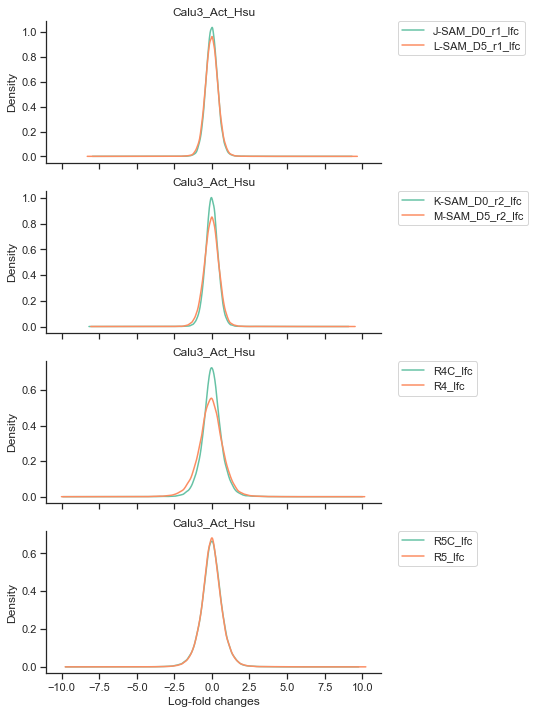

In [7]:
#Calculate log-fold change relative to pDNA
target_cols = list(lognorms.columns[3:])
pDNA_lfc = fns.calculate_lfc(lognorms,target_cols)

# Pair cols 
paired_cols = []
i = 0
j = 0 
for i, t in enumerate(treatment_cols):
    for j ,c in enumerate(control_cols):
        if i == j:
            c_new = c + '_lfc'
            t_new = t + '_lfc'
            pair = [c_new, t_new]
            paired_cols.append(pair)
        else:
            continue
paired_cols = True, paired_cols
        

#Plot population distributions of log-fold changes 
fns.lfc_dist_plot(pDNA_lfc, paired_cols=paired_cols, filename = 'Calu3_Act_Hsu', figsize=(6, 12))

### Control Distributions

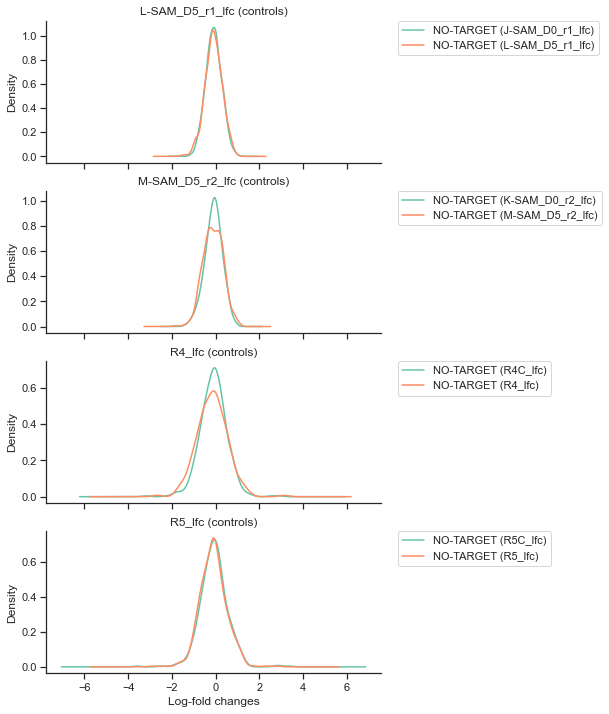

In [8]:
fns.control_dist_plot(pDNA_lfc, paired_cols=paired_cols, control_name=['NO-TARGET'], filename='Calu3_Act_Hsu', figsize=(6, 12))

## Gene-level analysis

### Residual z-scores

In [9]:
#Calculate z-scores of lfc residuals
lfc_df = pDNA_lfc.copy().drop(['Gene Symbol'], axis = 1)
lfc_df = lfc_df.dropna()
lfc_df = lfc_df.drop_duplicates()
paired_lfc_cols = paired_cols[1]

guide_residuals_lfcs, all_model_info, model_fit_plots = run_guide_residuals(lfc_df, paired_lfc_cols)

guide_mapping = pDNA_lfc[['Guide', 'Gene Symbol']]

gene_residuals = anchors.get_gene_residuals(guide_residuals_lfcs, guide_mapping)


          modified      unperturbed
0  L-SAM_D5_r1_lfc  J-SAM_D0_r1_lfc
1  M-SAM_D5_r2_lfc  K-SAM_D0_r2_lfc
2           R4_lfc          R4C_lfc
3           R5_lfc          R5C_lfc


In [10]:
gene_residual_sheet = fns.format_gene_residuals(gene_residuals, guide_min=2, guide_max=4, ascending=True)
guide_residual_sheet = pd.merge(guide_mapping, guide_residuals_lfcs, on = 'Guide', how = 'outer')

['R4_lfc', 'M-SAM_D5_r2_lfc', 'R5_lfc', 'L-SAM_D5_r1_lfc']
R4_lfc
M-SAM_D5_r2_lfc
R5_lfc
L-SAM_D5_r1_lfc


In [11]:
with pd.ExcelWriter('../../Data/Processed/GEO_submission_v2/Calu3_Act_Hsu_v1.xlsx') as writer:  
    gene_residual_sheet.to_excel(writer, sheet_name='Calu3_KO_avg_zscore', index =False)
    reads.to_excel(writer, sheet_name='Calu3_KO_genomewide_reads', index =False)
    guide_mapping.to_excel(writer, sheet_name='Calu3_KO_guide_mapping', index =False)

In [12]:
with pd.ExcelWriter('../../Data/Processed/Individual_screens_v2/Calu3_Act_Hsu_indiv_v1.xlsx') as writer:   
    gene_residuals.to_excel(writer, sheet_name='condition_genomewide_zscore', index =False)
    guide_residual_sheet.to_excel(writer, sheet_name='guide-level_zscore', index =False)

## Compare to Goujon data

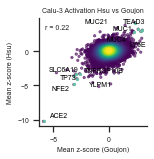

In [13]:
from adjustText import adjust_text

# Read Goujon Gattinara processed data
Goujon_Calu3_Cal = pd.read_excel('../../Data/Processed/GEO_submission_v2/Calu3_Calabrese_Goujon_v3.xlsx')
HsuvsGoujon_Calu3_act = pd.merge(Goujon_Calu3_Cal, gene_residual_sheet, on = 'Gene Symbol', suffixes = ['_Goujon', '_Hsu'])

fig, ax = plt.subplots(figsize=(2,2))
ax = gpp.point_densityplot(HsuvsGoujon_Calu3_act, 'residual_zscore_avg_Goujon', 'residual_zscore_avg_Hsu', s=6)
# ax = sns.scatterplot(data=HsuvsGoujon_Calu3_act, x='residual_zscore_avg_Goujon', y='residual_zscore_avg_Hsu', s=6, color='grey', edgecolor=None, alpha=0.5, rasterized=True)


ax = gpp.add_correlation(data=HsuvsGoujon_Calu3_act, x='residual_zscore_avg_Goujon', y='residual_zscore_avg_Hsu', loc='upper left', fontsize = 7)
top_ranked_Goujon = HsuvsGoujon_Calu3_act.nlargest(20, 'residual_zscore_avg_Goujon')
top_ranked_Hsu = HsuvsGoujon_Calu3_act.nlargest(20, 'residual_zscore_avg_Hsu')
top_ranked_Vero = pd.concat([top_ranked_Goujon, top_ranked_Hsu]).reset_index(drop = True).drop_duplicates()
bottom_ranked_Goujon = HsuvsGoujon_Calu3_act.nsmallest(20, 'residual_zscore_avg_Goujon')
bottom_ranked_Hsu = HsuvsGoujon_Calu3_act.nsmallest(20, 'residual_zscore_avg_Hsu')
bottom_ranked_Vero = pd.concat([bottom_ranked_Goujon, bottom_ranked_Hsu]).reset_index(drop = True).drop_duplicates()

ranked_Goujon = pd.concat([top_ranked_Goujon, bottom_ranked_Goujon])
ranked_Hsu = pd.concat([top_ranked_Hsu, bottom_ranked_Hsu])

# Label gene hits common to both screens 
common_ranked_Calu3_act = pd.merge(ranked_Goujon, ranked_Hsu, on =['Gene Symbol', 'residual_zscore_avg_Goujon', 'residual_zscore_avg_Hsu'], how = 'inner')

# ranked_Vero = pd.concat([top_ranked_Vero, bottom_ranked_Vero])
sns.scatterplot(data = common_ranked_Calu3_act, x='residual_zscore_avg_Goujon', y='residual_zscore_avg_Hsu', color = sns.color_palette('Set2')[0], edgecolor=None, s=6, rasterized=True)

texts= []
for j, row in common_ranked_Calu3_act.iterrows():
    texts.append(ax.text(row['residual_zscore_avg_Goujon']+0.25, row['residual_zscore_avg_Hsu'], row['Gene Symbol'], fontsize=7,
                                  color = 'black'))
        # ensures text labels are non-overlapping
    adjust_text(texts)
#     texts[j].set_bbox(dict(facecolor='white', alpha=0.75, edgecolor='black'))


plt.title('Calu-3 Activation Hsu vs Goujon', fontsize=7)
plt.xlabel('Mean z-score (Goujon)', fontsize=7)
plt.ylabel('Mean z-score (Hsu)', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)


# plt.gca().set_aspect('equal', adjustable='box')
ax.set_box_aspect(1)
sns.despine()
gpp.savefig('../../Figures/Scatterplots/Calu3act_HsuvsGoujon_scatterplot.pdf', dpi=300)
plt.savefig('../../Figures/Scatterplots/Calu3act_HsuvsGoujon_scatterplot.png', bbox_inches = 'tight')
